In [0]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P4'

In [0]:
import pandas as pd 

data = pd.read_csv("kaggle.csv") 

In [0]:
benign=data[data['label']=='good']
malicious=data[data['label']=='bad']

In [0]:
malicious.count()

url      75643
label    75643
dtype: int64

In [0]:
benign.count()

url      344821
label    344821
dtype: int64

In [0]:
ratio=len(malicious)/len(benign)
print(ratio)
benign=benign.sample(frac=ratio)

0.21936888994579795


In [0]:
X=benign.append(malicious)

In [0]:
X.count()

url      420464
label    420464
dtype: int64

In [0]:
X.iloc[40000]

url      en.wikipedia.org/wiki/Nesty
label                           good
Name: 82767, dtype: object

In [0]:
vocab={c:i+2 for i,c in enumerate('''0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ-._~:/?#[]@!$&'()*+,;%=''')}
vocab['[PAD]']=0
vocab['[UNK]']=1

In [0]:
print(vocab)

{'0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, 'A': 38, 'B': 39, 'C': 40, 'D': 41, 'E': 42, 'F': 43, 'G': 44, 'H': 45, 'I': 46, 'J': 47, 'K': 48, 'L': 49, 'M': 50, 'N': 51, 'O': 52, 'P': 53, 'Q': 54, 'R': 55, 'S': 56, 'T': 57, 'U': 58, 'V': 59, 'W': 60, 'X': 61, 'Y': 62, 'Z': 63, '-': 64, '.': 65, '_': 66, '~': 67, ':': 68, '/': 69, '?': 70, '#': 71, '[': 72, ']': 73, '@': 74, '!': 75, '$': 76, '&': 77, "'": 78, '(': 79, ')': 80, '*': 81, '+': 82, ',': 83, ';': 84, '%': 85, '=': 86, '[PAD]': 0, '[UNK]': 1}


In [0]:
class CharVocab():
  def __init__(self,vocab):
    self.vocab=vocab
  def ctoi(self,c):
    try:
      return self.vocab[c]
    except:
      return self.vocab['[UNK]']

In [0]:
char_vocab=CharVocab(vocab)

In [0]:
SEQUENCE_LENGTH=128

examples=[]
for index,row in X.iterrows():
  tokens=[char_vocab.ctoi(c) for c in row['url']][:SEQUENCE_LENGTH]
  tokens+=[char_vocab.ctoi('[PAD]') for i in range(SEQUENCE_LENGTH-len(tokens))]
  examples.append((tokens,int(row['label']=='bad')))

In [0]:
import torch
import torch.nn.functional as F

class URLGledac(torch.nn.Module):
  def __init__(self,sequence_length=128,embedding_size=32,hidden_size=128):
    super(URLGledac,self).__init__()

    self.embedding=torch.nn.Embedding(len(vocab),embedding_size)
    self.lstm=torch.nn.LSTM(embedding_size,hidden_size,bidirectional=True,num_layers=2,dropout=0.2)
    self.pool=torch.nn.MaxPool1d(sequence_length)
    self.dense=torch.nn.Linear(hidden_size*2,128)
    self.batch=torch.nn.BatchNorm1d(128)
    self.dropout=torch.nn.Dropout(0.2)
    self.output=torch.nn.Linear(128,2)

  def forward(self,url):
    #print(url.shape)
    embedding=self.embedding(url)
    #print(embedding.shape)
    out,_=self.lstm(torch.transpose(embedding,0,1))
    #print(out.shape)
    out=self.pool(torch.transpose(out,0,2))
    out=self.dense(torch.transpose(out.squeeze(dim=2),0,1))
    out=F.relu(out)
    out=self.batch(out)
    out=self.output(out)

    scores=torch.nn.functional.log_softmax(out,dim=1)

    return scores


In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def accuracy(predictions,labels):
  return accuracy_score(labels,predictions)

In [0]:
import numpy as np
import random

folds=5
random.shuffle(examples)
ratio=int(1/folds*len(examples))
X_folds=[]
for split in range(folds):
  train_set=examples[:split*ratio]+examples[(split+1)*ratio:]
  test_set=examples[split*ratio:(split+1)*ratio]
  X_folds.append((train_set,test_set))
  print(len(train_set))
  print(len(test_set))


336372
84092
336372
84092
336372
84092
336372
84092
336372
84092


In [0]:
import random

url_gledac=URLGledac()
url_gledac.cuda()

url_gledac.train()
loss=torch.nn.NLLLoss()
optimizer=torch.optim.Adam(url_gledac.parameters(),lr=5e-5,betas=(0.8,0.999))

BATCH_SIZE=128
for train_set, test_set in X_folds[0:1]:

  best_val_acc=0.
  for epoch in range(10):
    train_accuracy=0.
    train_loss=0.
    counter=0

    random.seed(69)
    random.shuffle(train_set)

    url_gledac.train()
    num_batches=len(train_set)//BATCH_SIZE
    for it in range(num_batches):
    #for url,label in train_set:
      urls=[url[0] for url in train_set[it*BATCH_SIZE:(it+1)*BATCH_SIZE]]
      labels=[url[1] for url in train_set[it*BATCH_SIZE:(it+1)*BATCH_SIZE]]

      counter+=1
      if counter%500==0:
        print('Train accuracy: %s loss: %s'%(train_accuracy/counter,train_loss/counter))
        counter=0
        train_accuracy=0.
        train_loss=0.

      #url=torch.tensor(url).unsqueeze(0).to(device)
      urls=torch.tensor(urls).to(device)
      scores=url_gledac(urls)

      #train_accuracy+=1. if torch.max(scores.cpu(),1)[1].item()==label else 0.
      #print(scores.shape)
      preds=torch.max(scores.cpu(),1)[1].detach().numpy()
      train_accuracy+=accuracy(labels,preds)
      
      labels=torch.tensor(labels).to(device)
      #label=torch.tensor(label).unsqueeze(0).to(device)
      loss_val=loss(scores,labels)

      train_loss+=loss_val.item()

      #print(loss_val)
      loss_val.backward()
      optimizer.step()

      
    print('Validation...')

    url_gledac.eval()
    validation_accuracy=0.
    num_batches=len(test_set)//BATCH_SIZE
    for it in range(num_batches):
    #for url,label in train_set:
      urls=[url[0] for url in test_set[it*BATCH_SIZE:(it+1)*BATCH_SIZE]]
      labels=[url[1] for url in test_set[it*BATCH_SIZE:(it+1)*BATCH_SIZE]]
      with torch.no_grad():
        urls=torch.tensor(urls).to(device)
        scores=url_gledac(urls)
        preds=torch.max(scores.cpu(),1)[1].detach().numpy()
        validation_accuracy+=accuracy(labels,preds)

    print('Validation accuracy: %s'%(validation_accuracy/num_batches)) 
    if best_val_acc<validation_accuracy/num_batches:
      best_val_acc=validation_accuracy/num_batches
      torch.save(url_gledac.state_dict(), 'forenzika_model'+str(round(validation_accuracy/num_batches,5)))
  print()
  print("Best result for fold: %s"%(best_val_acc))
  print()

Train accuracy: 0.813203125 loss: 0.4392803165912628
Train accuracy: 0.93453125 loss: 0.19806267829239368
Train accuracy: 0.95365625 loss: 0.12928789917379618
Train accuracy: 0.96071875 loss: 0.11096702927350997
Train accuracy: 0.964578125 loss: 0.10460640705935657
Validation...
Validation accuracy: 0.9683093559451219
Train accuracy: 0.967171875 loss: 0.0953153676148504
Train accuracy: 0.970734375 loss: 0.09284277200233192
Train accuracy: 0.974328125 loss: 0.08274199733883142
Train accuracy: 0.97490625 loss: 0.08330525983963162
Train accuracy: 0.975421875 loss: 0.0745852038115263
Validation...
Validation accuracy: 0.979027724847561
Train accuracy: 0.9773125 loss: 0.06094888239819556
Train accuracy: 0.980046875 loss: 0.05818241689167917
Train accuracy: 0.9810625 loss: 0.055900570208206775
Train accuracy: 0.98178125 loss: 0.05409956355020404
Train accuracy: 0.981546875 loss: 0.054647663303650916
Validation...
Validation accuracy: 0.9825528772865854
Train accuracy: 0.982578125 loss: 0.046

KeyboardInterrupt: ignored

##T-SNE

In [0]:
model_path='forenzika_model0.98361'

url_gledac=URLGledac()
url_gledac.cuda()
url_gledac.load_state_dict(torch.load(model_path))
url_gledac.eval()

URLGledac(
  (embedding): Embedding(87, 32)
  (lstm): LSTM(32, 128, num_layers=2, dropout=0.2, bidirectional=True)
  (pool): MaxPool1d(kernel_size=128, stride=128, padding=0, dilation=1, ceil_mode=False)
  (dense): Linear(in_features=256, out_features=128, bias=True)
  (batch): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=128, out_features=2, bias=True)
)

In [0]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

chars=[char_vocab.ctoi(c) for c in '''0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ-._~:/?#[]@!$&'()*+,;%=''']
labels=[c for c in '''0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ-._~:/?#[]@!$&'()*+,;%=''']
embedding=url_gledac.embedding(torch.tensor(chars).to(device))

In [0]:
embedding=embedding.cpu().detach().numpy()

In [0]:
tsne=TSNE(perplexity=5,learning_rate=10.,random_state=69)
new_embeddings=tsne.fit_transform(embedding)

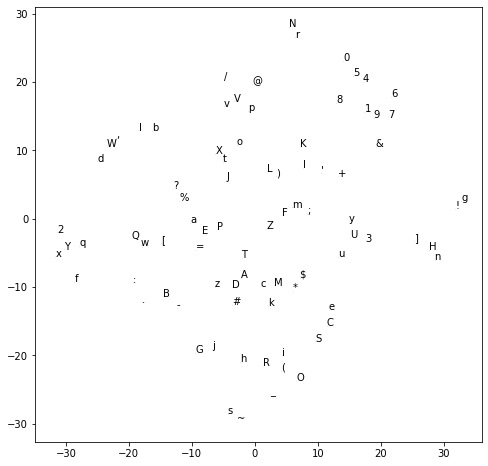

In [0]:
plt.figure(figsize=(8,8))
plt.scatter(new_embeddings[:,0],new_embeddings[:,1],marker='.',s=0.01)

for i,e in enumerate(new_embeddings):
  plt.annotate(labels[i],xy=e)

In [0]:
import numpy as np
from sklearn import metrics

url_gledac.eval()
pred=[]
y=[]
num_batches=len(test_set)//BATCH_SIZE
for it in range(num_batches):
  urls=[url[0] for url in test_set[it*BATCH_SIZE:(it+1)*BATCH_SIZE]]
  labels=[url[1] for url in test_set[it*BATCH_SIZE:(it+1)*BATCH_SIZE]]
  with torch.no_grad():
    urls=torch.tensor(urls).to(device)
    scores=url_gledac(urls)
    preds=torch.max(scores.cpu(),1)[1].detach()
    pred.append(preds)
    labels=torch.tensor(labels)
    y.append(labels)
pred=torch.cat(pred,0).squeeze().numpy()
y=torch.cat(y,0).squeeze().numpy()

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
auc=metrics.auc(fpr, tpr)

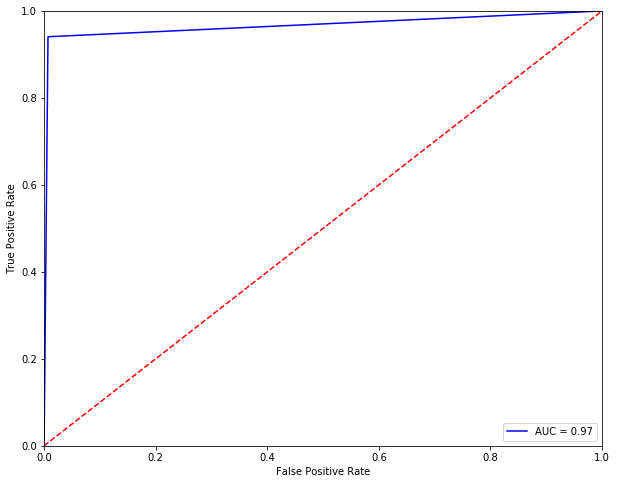

In [0]:
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
precision_recall_fscore_support(y,pred)

(array([0.98713715, 0.96689693]),
 array([0.9929793 , 0.94064808]),
 array([0.99004961, 0.95359191]),
 array([68939, 15029]))

In [0]:
precision_recall_fscore_support(y,pred,average='macro')

(0.9770170399623457, 0.966813690459497, 0.971820756450223, None)